In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models, datasets
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import VGG19_Weights
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
## Step 1: Load and Preprocess Data
# Define transformations for images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for pre-trained model input
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization for pre-trained models
])

In [3]:
!unzip -qq ./chip_data.zip -d data

In [4]:
# Load dataset from a folder (structured as: dataset/class_name/images)
dataset_path = "./data/dataset/"
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

In [5]:
# Display some input images
def show_sample_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(5, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Convert tensor format (C, H, W) to (H, W, C)
        axes[i].imshow(image)
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.show()

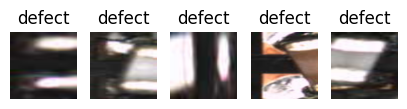

In [6]:
# Show sample images from the training dataset
show_sample_images(train_dataset)

In [7]:
# Get the total number of samples in the training dataset
print(f"Total number of training samples: {len(train_dataset)}")

# Get the shape of the first image in the dataset
first_image, label = train_dataset[0]
print(f"Shape of the first image: {first_image.shape}")

Total number of training samples: 172
Shape of the first image: torch.Size([3, 224, 224])


In [8]:
# Get the total number of samples in the testing dataset

print(f"Total number of test samples: {len(test_dataset)}")
# Get the shape of the first image in the dataset
first_image1, label = test_dataset[0]
print(f"Shape of the first image: {first_image1.shape}")


Total number of test samples: 121
Shape of the first image: torch.Size([3, 224, 224])


In [27]:
# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [28]:
## Step 2: Load Pretrained Model and Modify for Transfer Learning
# Load a pre-trained VGG19 model
# write your code here
model=models.vgg19(weights=VGG19_Weights.DEFAULT)








In [29]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [30]:
from torchsummary import summary
# Print model summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [31]:
# Modify the final fully connected layer to match the dataset classes
# Write your code here
model.classifier[-1]=nn.Linear(model.classifier[-1].in_features,1)




In [32]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [33]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [55]:
# Freeze all layers except the final layer
for param in model.features.parameters():
    param.requires_grad = False  # Freeze feature extractor layers

In [56]:
# Include the Loss function and optimizer
criterion =nn.BCEWithLogitsLoss()
optimizer =optim.Adam(model.parameters(), lr=0.001)

In [57]:
from torch.nn.modules import loss
## Step 3: Train the Model
def train_model(model, train_loader,test_loader,num_epochs=10):

    train_losses = []
    val_losses = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss  = criterion(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))


        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels.unsqueeze(1).float())
                val_loss += loss.item()
        val_losses.append(val_loss / len(test_loader))
        model.train()
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')


    print("Name:MANIKANDAN T")
    print("Register Number:212224110037")
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

In [58]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Epoch [1/10], Train Loss: 0.0011, Validation Loss: 0.2501
Epoch [2/10], Train Loss: 0.0000, Validation Loss: 0.5669
Epoch [3/10], Train Loss: 0.0000, Validation Loss: 0.2348
Epoch [4/10], Train Loss: 0.0000, Validation Loss: 0.2362
Epoch [5/10], Train Loss: 0.0001, Validation Loss: 2.9891
Epoch [6/10], Train Loss: 0.0416, Validation Loss: 0.2397
Epoch [7/10], Train Loss: 0.0000, Validation Loss: 1.7756
Epoch [8/10], Train Loss: 0.0004, Validation Loss: 0.4872
Epoch [9/10], Train Loss: 0.0763, Validation Loss: 4.0625
Epoch [10/10], Train Loss: 0.4557, Validation Loss: 0.9794
Name:MANIKANDAN T
Register Number:212224110037


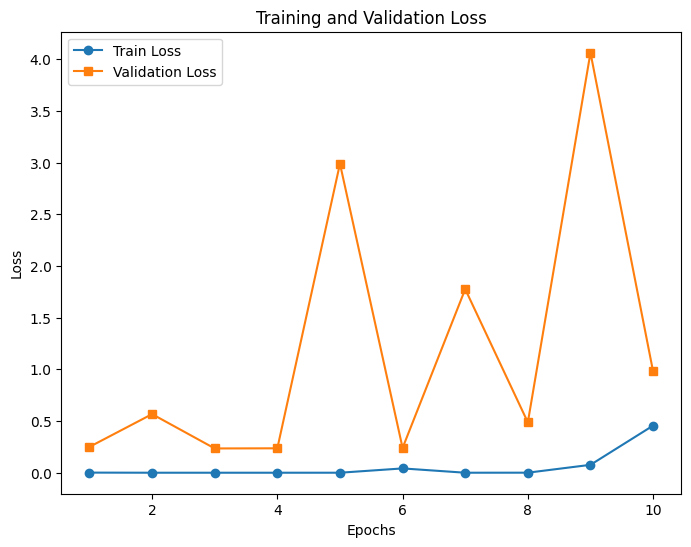

In [59]:
# Train the model
# Write your code here
train_model(model, train_loader,test_loader)






In [60]:
## Step 4: Test the Model and Compute Confusion Matrix & Classification Report
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Name:MANIKANDAN T ")
    print("Register Number:212224110037")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("Name: MANIKANDAN T")
    print("Register Number:212224110037")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


Test Accuracy: 0.2727
Name:MANIKANDAN T 
Register Number:212224110037


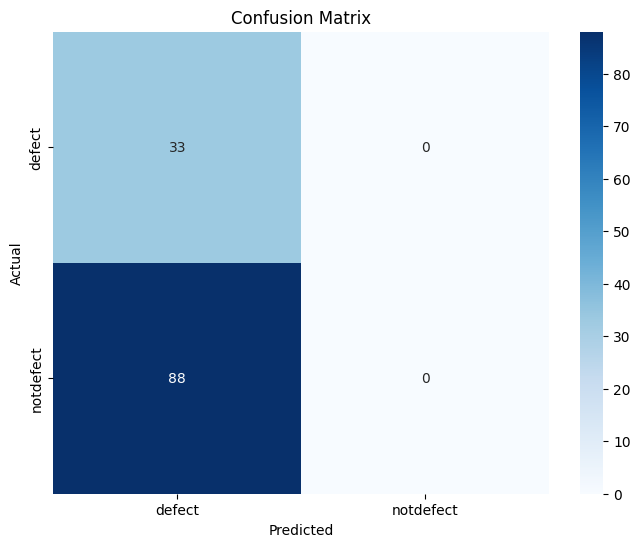

Name: MANIKANDAN T
Register Number:212224110037
Classification Report:
              precision    recall  f1-score   support

      defect       0.27      1.00      0.43        33
   notdefect       0.00      0.00      0.00        88

    accuracy                           0.27       121
   macro avg       0.14      0.50      0.21       121
weighted avg       0.07      0.27      0.12       121



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [61]:
# Evaluate the model
# write your code here
test_model(model, test_loader)




In [63]:
## Step 5: Predict on a Single Image and Display It
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    with torch.no_grad():
        image_tensor = image.unsqueeze(0).to(device)
        output = model(image_tensor)

        # Apply sigmoid to get probability, threshold at 0.5
        prob = torch.sigmoid(output)
        predicted = (prob > 0.5).int().item()


    class_names = class_names = dataset.classes
    # Display the image
    image_to_display = transforms.ToPILImage()(image)
    plt.figure(figsize=(4, 4))
    plt.imshow(image_to_display)
    plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted]}')
    plt.axis("off")
    plt.show()
    print("Name: MANIKANDAN T")
    print("Register Number:212224110037")


    print(f'Actual: {class_names[label]}, Predicted: {class_names[predicted]}')

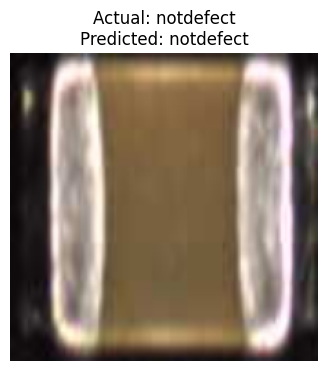

Name: MANIKANDAN T
Register Number:212224110037
Actual: notdefect, Predicted: notdefect


In [64]:
# Example Prediction
predict_image(model, image_index=55, dataset=test_dataset)


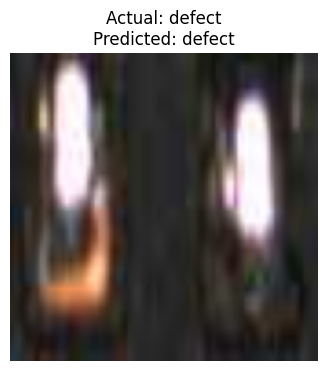

Name: MANIKANDAN T
Register Number:212224110037
Actual: defect, Predicted: defect


In [66]:
#Example Prediction
predict_image(model, image_index=25, dataset=test_dataset)

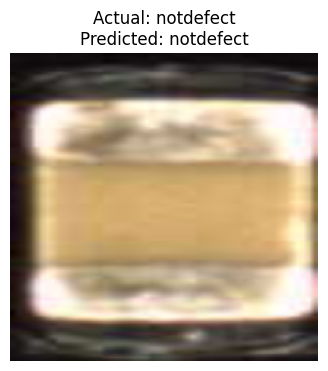

Name: MANIKANDAN T
Register Number:212224110037
Actual: notdefect, Predicted: notdefect


In [67]:
predict_image(model, image_index=75, dataset=test_dataset)